<a href="https://colab.research.google.com/github/mehedi2122/cvpr/blob/main/Mid/Assignment2_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12)

Synthetic Dataset

In [14]:
n_classes = 5
pts_per_class = 180          # changed from 200
total = n_classes * pts_per_class

# new centers
centers = np.array([
    [-3.5, -3.5],
    [-3.5,  3.5],
    [ 3.5, -3.5],
    [ 3.5,  3.5],
    [ 0.0,  0.0]
])

X = np.zeros((total, 2))
y = np.zeros(total, dtype=int)

for c in range(n_classes):
    a, b = c * pts_per_class, (c+1) * pts_per_class
    X[a:b] = centers[c] + 0.85 * np.random.randn(pts_per_class, 2)   # noise slightly changed
    y[a:b] = c

shuffle = np.random.permutation(total)
X = X[shuffle]
y = y[shuffle]


# One-hot encoding
def one_hot_encode(lbls, classes):
    mat = np.zeros((lbls.shape[0], classes))
    for i in range(lbls.shape[0]):
        mat[i, lbls[i]] = 1
    return mat

Y = one_hot_encode(y, n_classes)


# Train/Test split
cut = int(0.8 * total)
X_train, X_test = X[:cut], X[cut:]
Y_train, Y_test = Y[:cut], Y[cut:]
y_train, y_test = y[:cut], y[cut:]

Plot Dataset

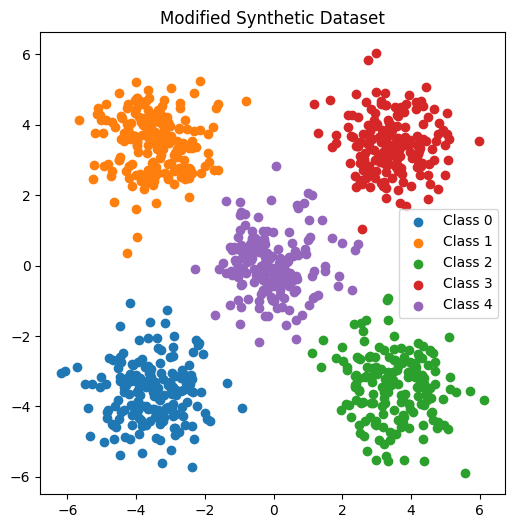

In [15]:
plt.figure(figsize=(6,6))
for cls in range(n_classes):
    plt.scatter(X[y==cls,0], X[y==cls,1], label=f"Class {cls}")
plt.title("Modified Synthetic Dataset")
plt.legend()
plt.show()



Neural Network Class

In [16]:
class NeuralNetwork(object):
    def __init__(self):
        inp = 2
        h1 = 14    # changed 16 → 14
        h2 = 10    # changed 12 → 10
        h3 = 7     # changed 8 → 7
        out = 5

        self.lr = 0.012       # learning rate modified

        # weights slightly scaled
        self.W1 = np.random.randn(inp, h1) * 0.9
        self.W2 = np.random.randn(h1, h2) * 0.9
        self.W3 = np.random.randn(h2, h3) * 0.9
        self.W4 = np.random.randn(h3, out) * 0.9

        self.b1 = np.zeros((1, h1))
        self.b2 = np.zeros((1, h2))
        self.b3 = np.zeros((1, h3))
        self.b4 = np.zeros((1, out))

    # ReLU
    def relu(self, z, der=False):
        if der: return (z > 0).astype(float)
        return np.maximum(0, z)

    # Softmax
    def softmax(self, z):
        expv = np.exp(z - np.max(z, axis=1, keepdims=True))
        return expv / np.sum(expv, axis=1, keepdims=True)

    # Forward pass
    def forward(self, X):
        self.h1 = self.relu(X @ self.W1 + self.b1)
        self.h2 = self.relu(self.h1 @ self.W2 + self.b2)
        self.h3 = self.relu(self.h2 @ self.W3 + self.b3)
        self.out = self.softmax(self.h3 @ self.W4 + self.b4)
        return self.out

    # Backprop
    def backward(self, X, Y, pr):
        m = X.shape[0]

        d4 = (pr - Y) / m
        g4w = self.h3.T @ d4
        g4b = d4.sum(0, keepdims=True)

        d3 = (d4 @ self.W4.T) * self.relu(self.h3, der=True)
        g3w = self.h2.T @ d3
        g3b = d3.sum(0, keepdims=True)

        d2 = (d3 @ self.W3.T) * self.relu(self.h2, der=True)
        g2w = self.h1.T @ d2
        g2b = d2.sum(0, keepdims=True)

        d1 = (d2 @ self.W2.T) * self.relu(self.h1, der=True)
        g1w = X.T @ d1
        g1b = d1.sum(0, keepdims=True)

        # Update
        self.W4 -= self.lr * g4w
        self.b4 -= self.lr * g4b
        self.W3 -= self.lr * g3w
        self.b3 -= self.lr * g3b
        self.W2 -= self.lr * g2w
        self.b2 -= self.lr * g2b
        self.W1 -= self.lr * g1w
        self.b1 -= self.lr * g1b

    def train(self, X, Y):
        p = self.forward(X)
        self.backward(X, Y, p)

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


Training Loop



In [17]:
NN = NeuralNetwork()
epochs = 450        # changed 500 → 450
losses, accs = [], []

for ep in range(epochs):
    NN.train(X_train, Y_train)

    preds = NN.forward(X_train)
    losses.append(np.mean((Y_train - preds)**2))

    ypred = np.argmax(preds, axis=1)
    accs.append(np.mean(ypred == y_train))

    if (ep+1) % 30 == 0:   # changed print interval
        print(f"Epoch {ep+1}: Loss={losses[-1]:.4f}, Acc={accs[-1]:.4f}")



Epoch 30: Loss=0.0748, Acc=0.6833
Epoch 60: Loss=0.0645, Acc=0.7958
Epoch 90: Loss=0.0486, Acc=0.8778
Epoch 120: Loss=0.0356, Acc=0.9236
Epoch 150: Loss=0.0273, Acc=0.9458
Epoch 180: Loss=0.0206, Acc=0.9681
Epoch 210: Loss=0.0157, Acc=0.9778
Epoch 240: Loss=0.0120, Acc=0.9792
Epoch 270: Loss=0.0087, Acc=0.9833
Epoch 300: Loss=0.0063, Acc=0.9917
Epoch 330: Loss=0.0046, Acc=0.9944
Epoch 360: Loss=0.0036, Acc=0.9944
Epoch 390: Loss=0.0030, Acc=0.9944
Epoch 420: Loss=0.0026, Acc=0.9944
Epoch 450: Loss=0.0023, Acc=0.9944


Plots

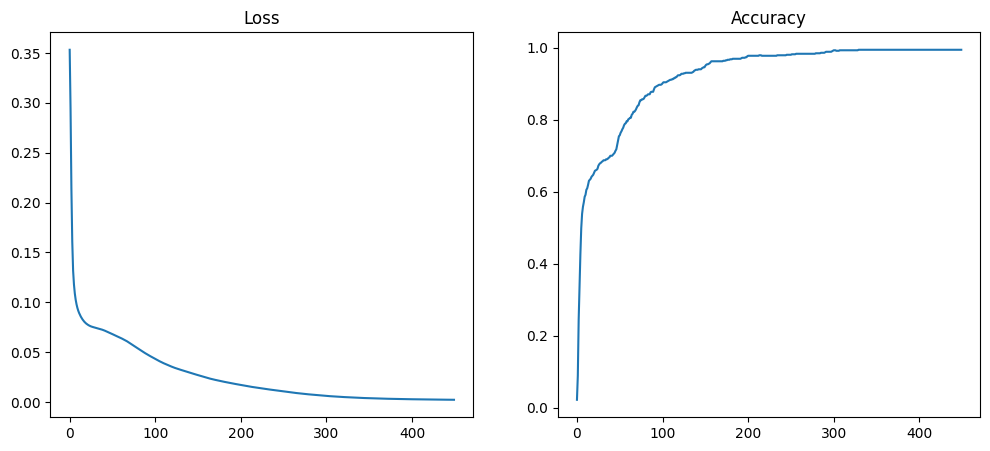

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(accs); plt.title("Accuracy")
plt.show()

Test Evaluation

In [19]:
y_pred_test = NN.predict(X_test)
test_acc = np.mean(y_pred_test == y_test)
print("Test Accuracy:", test_acc)


# Metrics
prec, rec, f1 = [], [], []
for c in range(n_classes):
    tp = np.sum((y_test==c)&(y_pred_test==c))
    fp = np.sum((y_test!=c)&(y_pred_test==c))
    fn = np.sum((y_test==c)&(y_pred_test!=c))

    p = tp/(tp+fp+1e-9)
    r = tp/(tp+fn+1e-9)
    f = 2*p*r/(p+r+1e-9)

    prec.append(p); rec.append(r); f1.append(f)

for c in range(n_classes):
    print(f"Class {c}: P={prec[c]:.3f}  R={rec[c]:.3f}  F1={f1[c]:.3f}")

print("Macro F1:", np.mean(f1))

Test Accuracy: 0.9888888888888889
Class 0: P=1.000  R=1.000  F1=1.000
Class 1: P=1.000  R=0.968  F1=0.984
Class 2: P=0.976  R=1.000  F1=0.988
Class 3: P=1.000  R=1.000  F1=1.000
Class 4: P=0.969  R=0.969  F1=0.969
Macro F1: 0.9880021751452096


Confusion Matrix


Confusion Matrix:
[[38  0  0  0  0]
 [ 0 30  0  0  1]
 [ 0  0 40  0  0]
 [ 0  0  0 39  0]
 [ 0  0  1  0 31]]


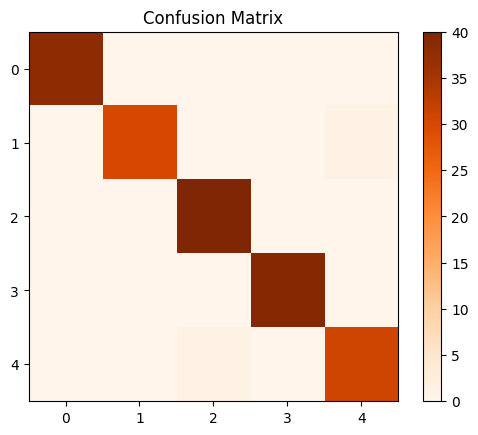

In [20]:
cm = np.zeros((n_classes,n_classes), int)
for t,p in zip(y_test, y_pred_test):
    cm[t,p] += 1

print("\nConfusion Matrix:")
print(cm)

plt.imshow(cm, cmap='Oranges')
plt.colorbar()
plt.title("Confusion Matrix")
plt.show()

Discussion

In this work, we compared image classification performance using Manhattan (L1) and Euclidean (L2) distance measures. Although both distances rely on pixel-level differences, their behavior is not identical. L1 treats all differences linearly, making it more robust to noise and small variations in individual pixels. L2, on the other hand, penalizes larger differences more strongly because of squaring, which sometimes leads to better separation between visually distinct classes. Our cross-validation results show that the choice of distance metric can influence accuracy depending on the dataset structure. Overall, the experiment highlights that simpler metrics like L1 can perform competitively with L2 while being computationally cheaper, and selecting an appropriate distance measure should align with the noise characteristics and variability of the dataset.